## A RNN model to analyse stock prices

RNN are a type of deep learning architecture suited to work with **longitudinal data**, e.g. time series data.
Time series data include many types of data, like economic indicators (e.g. *quarterly GDP*, *monthly inflation*) and patient health evolution metrics (e.g.*ECG data*).
Time series data include a fundamental **time component**, and are often used in **forecasting problems**.

Here we use Amazon stock prices over time as an example to train a recurrent neural network (RNN) model.


In [8]:
## import relevant libraries
import numpy as np
import datetime as dt
import pandas as pd
import pandas_datareader
from pandas_datareader import data

In [9]:
## getting the data
DATAURL = 'https://raw.githubusercontent.com/ne1s0n/coding_excercises/master/data/amazon_stock_prices.csv'
df = pd.read_csv(DATAURL)
print("N. of row in dataframe: ",len(df))
df.head()

N. of row in dataframe:  5454


,High,Low,Open,Close,Volume,Adj Close
0,89.5625,79.046875,81.5000,89.3750,16117600,89.3750
1,91.5000,81.750000,85.3750,81.9375,17487400,81.9375
2,75.1250,68.000000,70.5000,69.7500,38457400,69.7500
3,72.6875,64.000000,71.3125,65.5625,18752000,65.5625
4,70.5000,66.187500,67.0000,69.5625,10505400,69.5625


We will use AMZN closing prices (`Close`) in a forecasting problem

First, we split data into train/test

In [10]:
prices = df['Close']
n = 5000 # training set
train = list(prices)[:n] #first n prices
test = list(prices)[n:] #remaining prices

#### Data representation

We have two series of data (prices), for training and for testing.
For training, we have therefore one data series, and we need to use an appropriate representation for the feature data to be used for prediction (forecasting).

A common possibility is to use preceding values in the series to predict the next one(s): for instance, a sliding-window appraoch can be used (see figure below)

<img src="https://miro.medium.com/max/700/1*murkc0tNsvgdQDVgKqSdfQ.png">

In [11]:
## prepare the training data
windowSize, X_train, y_train = 10, [], [] #initialize lists and set window size
for index in range(len(train)-windowSize): #we must end at train-windowSize to avoid the windowSize going past the end
    X_train.append(train[index:index+windowSize]) #append the range from index to index+windowSize to x
    y_train.append(train[index+windowSize]) #append the next value to the y

X_train,y_train = np.array(X_train), np.array(y_train) #convert to numpy array
X_train = X_train.reshape((len(X_train), windowSize, 1)) #reshape X_train to proper 3-d array

print(y_train.shape)
print(X_train.shape)

(4990,)
(4990, 10, 1)


In [16]:
X_train[0,0:9,0]

array([89.375 , 81.9375, 69.75  , 65.5625, 69.5625, 69.1875, 66.75  ,
       63.5625, 65.9375])

In [19]:
y_train[0]

64.125

3D input X array for RNN; usually we have:

- n. of records
- n. of features
- time (longitudinal) dimension

E.g. 48 hourly blood-pressure measurements, min/max (diastolic/sistolic), on 1000 patients:

`(1000 x 48 x 2)`

Also, the examples we saw for text processing, e.g. 100 sentences of max 24 words, a vocabulary of size 10,000:

`(100 x 24 10000)`

In [20]:
## prepare the test data
windowSize, X_test, y_test = 10, [], [] #initialize lists and set window size
for index in range(len(test)-windowSize): #we must end at train-windowSize to avoid the windowSize going past the end
    X_test.append(test[index:index+windowSize]) #append the range from index to index+windowSize to x
    y_test.append(test[index+windowSize]) #append the next value to the y

X_test,y_test = np.array(X_test), np.array(y_test) #convert to numpy array
X_test = X_test.reshape((len(X_test), windowSize, 1)) #reshape X_train to proper 3-d array

print(y_test.shape)
print(X_test.shape)

(444,)
(444, 10, 1)


### Simple RNN

Let's start with a simple RNN model:
- one RNN layer (10 units)
- one dense layer (output layer: one number per timepoint, regression problem)

In [21]:
from keras import Sequential
from keras.layers import SimpleRNN, Dense

import math
import tensorflow as tf
import matplotlib.pyplot as plt

In [22]:
model = Sequential() #initializing sequential model, layers can be added sequentially with model.add
model.add(SimpleRNN(10, input_shape=(windowSize,1))) #simple recurrent layer, 10 neurons & process 10x1 sequences
model.add(Dense(1,activation='linear')) #linear output because this is a regression problem
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn (SimpleRNN)       (None, 10)                120       
_________________________________________________________________
dense (Dense)                (None, 1)                 11        
Total params: 131
Trainable params: 131
Non-trainable params: 0
_________________________________________________________________


- 10 units
- recurrent weights (states/activations are fed recursively): matrix $\mathbf{W_{aa}}(u,u)$
- input weights: n. units x n. features (here the number of features is 1: one sequence of previous values). For the blood pressure example, this would be 2 (diastolic and sistolic pressure values)
- one bias term per unit

$$
120 = 10 \text{ units} \cdot 10 \text{ units} + 10 \text{ units} \cdot 1 \text{ feature} + 10 \text{ bias terms} 
$$

In [23]:
## let's fit the model
loss_function = 'mse'
optimizer_algorithm = 'Adam'
metrics_list = ['mae',tf.keras.metrics.RootMeanSquaredError()]
n_epochs = 20

model.compile(loss=loss_function, optimizer=optimizer_algorithm, metrics=metrics_list)
history = model.fit(X_train,y_train,epochs=n_epochs, verbose=0, validation_data=(X_test, y_test))

dict_keys(['loss', 'mae', 'root_mean_squared_error', 'val_loss', 'val_mae', 'val_root_mean_squared_error'])


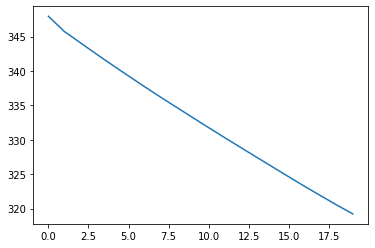

In [24]:
print(history.history.keys())
plt.plot(history.history['mae'])

In [25]:
## let's look at predictions
predictions = model.predict(X_test)
nrow = len(y_test)
temp = y_test.reshape(nrow,1)

## MAPE
ptc_err = 100*(abs(predictions - temp)/abs(temp))
mape = ptc_err.mean() # mean absolute percentage error

## RMSE
sqerr = (predictions - y_test)**2
rmse = math.sqrt(sqerr.mean())

print("accuracy (measured as MAPE) is: ", round(mape,2), " %")
print("accuracy (measured as RMSE) is: ", round(rmse,2), " dollars")

accuracy (measured as MAPE) is:  98.64  %
accuracy (measured as RMSE) is:  2897.92  dollars


     index       y_test     y_pred
0        0  1781.599976  37.295757
1        1  1769.959961  37.295757
2        2  1760.689941  37.295757
3        3  1740.479980  37.295757
4        4  1751.599976  37.295757
..     ...          ...        ...
439    439  3421.570068  37.295757
440    440  3470.790039  37.295757
441    441  3479.000000  37.295757
442    442  3463.120117  37.295757
443    443  3478.050049  37.295757

[444 rows x 3 columns]


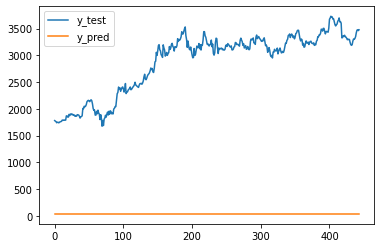

In [26]:
y_pred = pd.Series(predictions[:,0])
y = pd.Series(y_test.astype(float))

df = pd.DataFrame(dict(y_test = y, y_pred = y_pred)).reset_index()
print(df)
df[['y_test','y_pred']].plot()

Why is it so? We see that predictions are stuck at one single value, some sort of upper bound. Let's look back at the data:

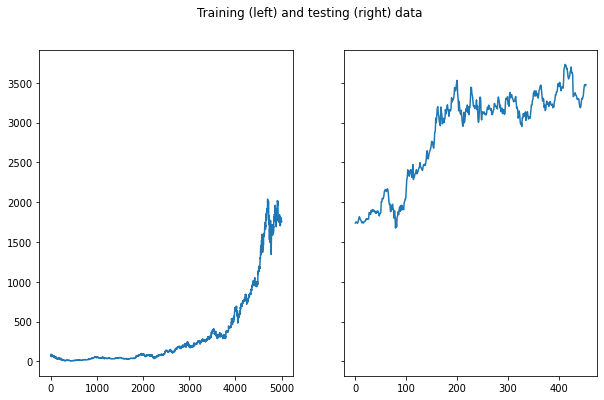

In [27]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10,6), sharey=True)
fig.suptitle('Training (left) and testing (right) data')
ax1.plot(train)
ax2.plot(test)

### Normalising the data

To avoid problems with different ranges, we take the percentage sequential differences rather than the raw values. 

First, the training data:

In [28]:
train_norm = np.diff(train)
test_norm = np.diff(test)

In [29]:
train_perc = (train_norm/train[:-1])*100

windowSize, X_train, y_train = 10, [], [] #initialize lists and set window size
for index in range(len(train_perc)-windowSize): #we must end at train-windowSize to avoid the windowSize going past the end
    X_train.append(train_perc[index:index+windowSize]) #append the range from index to index+windowSize to x
    y_train.append(train_perc[index+windowSize]) #append the next value to the y

X_train,y_train = np.array(X_train), np.array(y_train) #convert to numpy array
X_train = X_train.reshape((len(X_train), windowSize, 1)) #reshape X_train to proper 3-d array

print(y_train.shape)
print(X_train.shape)
print(train[1:10])
print(train_perc[1:10])

(4989,)
(4989, 10, 1)
[81.9375, 69.75, 65.5625, 69.5625, 69.1875, 66.75, 63.5625, 65.9375, 64.25]
[-14.87414188  -6.00358423   6.10104862  -0.53908356  -3.52303523
  -4.7752809    3.73647984  -2.55924171  -0.19455253]


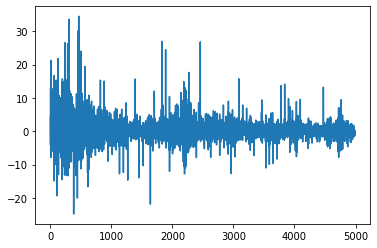

In [31]:
plt.plot(y_train)

Now the test data:

(443,)
(443, 10, 1)


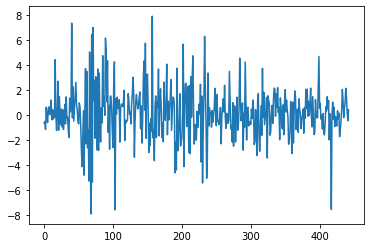

In [30]:
## test data
test_perc = (test_norm/test[:-1])*100

windowSize, X_test, y_test = 10, [], [] #initialize lists and set window size
for index in range(len(test_perc)-windowSize): #we must end at train-windowSize to avoid the windowSize going past the end
    X_test.append(test_perc[index:index+windowSize]) #append the range from index to index+windowSize to x
    y_test.append(test_perc[index+windowSize]) #append the next value to the y

X_test,y_test = np.array(X_test), np.array(y_test) #convert to numpy array
X_test = X_test.reshape((len(X_test), windowSize, 1)) #reshape X_train to proper 3-d array

print(y_test.shape)
print(X_test.shape)
plt.plot(y_test)

Let's fit again the RNN model:

In [32]:
model = Sequential() #initializing sequential model, layers can be added sequentially with model.add
model.add(SimpleRNN(10, input_shape=(windowSize,1))) #simple recurrent layer, 10 neurons & process 50x1 sequences
model.add(Dense(1,activation='linear')) #linear output because this is a regression problem
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_1 (SimpleRNN)     (None, 10)                120       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 11        
Total params: 131
Trainable params: 131
Non-trainable params: 0
_________________________________________________________________


In [33]:
loss_function = 'mse'
optimizer_algorithm = 'Adam'
metrics_list = ['mae',tf.keras.metrics.RootMeanSquaredError()]
n_epochs = 20

model.compile(loss=loss_function, optimizer=optimizer_algorithm, metrics=metrics_list)
history = model.fit(X_train,y_train,epochs=n_epochs, verbose=0, validation_data=(X_test, y_test))

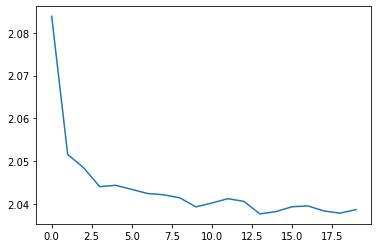

In [34]:
plt.plot(history.history['mae'])

In [35]:
## let's look at predictions
predictions = model.predict(X_test)
nrow = len(y_test)
temp = y_test.reshape(nrow,1)

## MAPE
ptc_err = 100*(abs(predictions - temp)/abs(temp))
mape = ptc_err.mean() # mean absolute percentage error

## RMSE
sqerr = (predictions - y_test)**2
rmse = math.sqrt(sqerr.mean())

print("accuracy (measured as MAPE) is: ", round(mape,2), " %")
print("accuracy (measured as RMSE) is: ", round(rmse,2), " pct points change")

accuracy (measured as MAPE) is:  115.52  %
accuracy (measured as RMSE) is:  2.08  pct points change


     index    y_test    y_pred
0        0 -0.653346 -0.067186
1        1 -0.523742  0.238388
2        2 -1.147843  0.242942
3        3  0.638904  0.421347
4        4 -0.119318  0.251767
..     ...       ...       ...
438    438  2.147706  0.082113
439    439  1.438520  0.200223
440    440  0.236544  0.056073
441    441 -0.456450 -0.042928
442    442  0.431112 -0.090497

[443 rows x 3 columns]


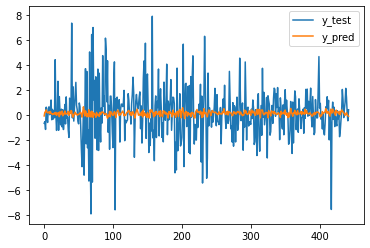

In [36]:
y_pred = pd.Series(predictions[:,0])
y = pd.Series(y_test.astype(float)) 

df = pd.DataFrame(dict(y_test = y, y_pred = y_pred)).reset_index()
print(df)
df[['y_test','y_pred']].plot()

#### Backtransform the data

Let's put our data back on the dollar scale

In [37]:
print(y_test[1:10])
print(test[1:10])

[-0.52374176 -1.14784327  0.63890394 -0.11931753 -0.58873906  0.54680056
  0.66391335  0.03465176  0.46963666]
[1752.530029296875, 1752.7900390625, 1745.530029296875, 1734.7099609375, 1745.719970703125, 1773.8399658203125, 1796.93994140625, 1818.510009765625, 1800.800048828125]


[1728.12509955 1718.94636785 1698.82708541 1709.97934549 1707.90953242
 1697.63179703 1707.33116385 1719.26128803 1719.89143379]
[1752.530029296875, 1752.7900390625, 1745.530029296875, 1734.7099609375, 1745.719970703125, 1773.8399658203125, 1796.93994140625, 1818.510009765625, 1800.800048828125]
     index       y_test       y_pred
0        0  1739.489990  1739.489990
1        1  1728.125100  1738.321295
2        2  1718.946368  1742.499116
3        3  1698.827085  1746.757384
4        4  1709.979345  1754.112114
..     ...          ...          ...
439    439  3414.974553  3615.400006
440    440  3462.431184  3622.005347
441    441  3470.099860  3623.823210
442    442  3455.487904  3622.449005
443    443  3469.230681  3619.564181

[444 rows x 3 columns]


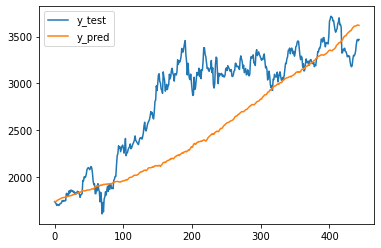

In [38]:
y_temp = (y_test.reshape(nrow,)/100)*test[:-(windowSize+1)]
y_orig = np.append(test[0], y_temp)
y_orig = np.cumsum(y_orig)

print(y_orig[1:10])
print(test[1:10])

y_temp = (y_pred/100)*test[:-(windowSize+1)]
y_pred_back = np.append(test[0], y_temp)
y_pred_back = np.cumsum(y_pred_back)

df = pd.DataFrame(dict(y_test = y_orig, y_pred = y_pred_back)).reset_index()
print(df)
df[['y_test','y_pred']].plot()

In [49]:
## MAPE
ytt = df[['y_test']].values
ypp = df[['y_pred']].values
ptc_err = 100*(abs(ytt - ypp)/abs(ytt))
mape = ptc_err.mean() # mean absolute percentage error
rmse = np.sqrt(sum((ytt-ypp)**2)/len(ytt))

print("accuracy (measured as MAPE) is: ", round(mape,2), " %")
print("accuracy (measured as RMSE) is: ", np.round(rmse,2), " dollars")

accuracy (measured as MAPE) is:  12.22  %
accuracy (measured as RMSE) is:  [467.23]  dollars


---
# END OF LIGHT DEMO PART - from now on: hic sunt leones!
---

### More RNN layers

Let's now make our neural network model more complex by adding layers (going "deep").

First, a sanity check on the input data:

In [51]:
print(y_train[0:9])
print(X_train[0:4,0:4])
print(X_test[1:5,1:5])
print(y_test[1:10])

[ 4.19103314 -3.08699719 -4.15057915 12.99093656 -1.24777184 -6.40794224
  3.27868852 -7.84313725  4.66058764]
[[[ -8.32167832]
  [-14.87414188]
  [ -6.00358423]
  [  6.10104862]]

 [[-14.87414188]
  [ -6.00358423]
  [  6.10104862]
  [ -0.53908356]]

 [[ -6.00358423]
  [  6.10104862]
  [ -0.53908356]
  [ -3.52303523]]

 [[  6.10104862]
  [ -0.53908356]
  [ -3.52303523]
  [ -4.7752809 ]]]
[[[-0.41419734]
  [-0.61987294]
  [ 0.6346888 ]
  [ 1.61079644]]

 [[-0.61987294]
  [ 0.6346888 ]
  [ 1.61079644]
  [ 1.30225815]]

 [[ 0.6346888 ]
  [ 1.61079644]
  [ 1.30225815]
  [ 1.20037781]]

 [[ 1.61079644]
  [ 1.30225815]
  [ 1.20037781]
  [-0.97387206]]]
[-0.52374176 -1.14784327  0.63890394 -0.11931753 -0.58873906  0.54680056
  0.66391335  0.03465176  0.46963666]


Now we build, compile and fit the model

In [52]:
model = Sequential() #initialize model
model.add(SimpleRNN(32, input_shape=(windowSize,1), return_sequences=True)) #recurrent layer 1, 64 neurons
model.add(SimpleRNN(16, return_sequences=True)) #recurrent layer 2, 32 neurons
model.add(SimpleRNN(8)) #recurrent layer 3, 16 neurons
model.add(Dense(1,activation='linear')) #output dense layer (1 neuron) w/ linear activation
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_2 (SimpleRNN)     (None, 10, 32)            1088      
_________________________________________________________________
simple_rnn_3 (SimpleRNN)     (None, 10, 16)            784       
_________________________________________________________________
simple_rnn_4 (SimpleRNN)     (None, 8)                 200       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 9         
Total params: 2,081
Trainable params: 2,081
Non-trainable params: 0
_________________________________________________________________


In [53]:
loss_function = 'mse'
optimizer_algorithm = 'Adam'
metrics_list = ['mae',tf.keras.metrics.RootMeanSquaredError()]
n_epochs = 20

model.compile(loss=loss_function, optimizer=optimizer_algorithm, metrics=metrics_list)
history = model.fit(X_train,y_train,epochs=n_epochs, verbose=0, validation_data=(X_test, y_test))

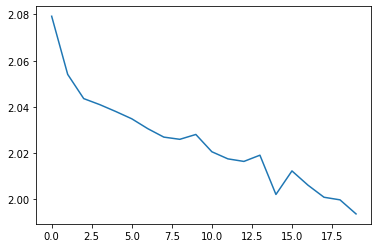

In [54]:
plt.plot(history.history['mae'])

[1728.12509955 1718.94636785 1698.82708541 1709.97934549 1707.90953242
 1697.63179703 1707.33116385 1719.26128803 1719.89143379]
[1752.530029296875, 1752.7900390625, 1745.530029296875, 1734.7099609375, 1745.719970703125, 1773.8399658203125, 1796.93994140625, 1818.510009765625, 1800.800048828125]
     index       y_test       y_pred
0        0  1739.489990  1739.489990
1        1  1728.125100  1740.489751
2        2  1718.946368  1750.597963
3        3  1698.827085  1755.142643
4        4  1709.979345  1753.255932
..     ...          ...          ...
439    439  3414.974553  2086.993496
440    440  3462.431184  2108.845493
441    441  3470.099860  2103.407563
442    442  3455.487904  2111.943847
443    443  3469.230681  2130.690674

[444 rows x 3 columns]


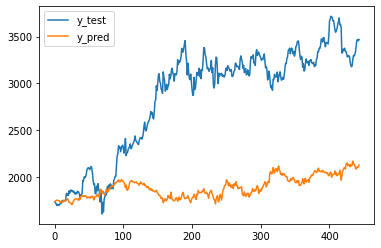

In [55]:
predictions = model.predict(X_test)
y_pred = pd.Series(predictions[:,0])
y = pd.Series(y_test.astype(float))
df = pd.DataFrame(dict(y_test = y, y_pred = y_pred)).reset_index()

y_temp = (y_test.reshape(nrow,)/100)*test[:-(windowSize+1)]
y_orig = np.append(test[0], y_temp)
y_orig = np.cumsum(y_orig)

print(y_orig[1:10])
print(test[1:10])

y_temp = (y_pred/100)*test[:-(windowSize+1)]
y_pred_back = np.append(test[0], y_temp)
y_pred_back = np.cumsum(y_pred_back)

df = pd.DataFrame(dict(y_test = y_orig, y_pred = y_pred_back)).reset_index()
print(df)
df[['y_test','y_pred']].plot()

In [56]:
## MAPE
ytt = df[['y_test']].values
ypp = df[['y_pred']].values
ptc_err = 100*(abs(ytt - ypp)/abs(ytt))
mape = ptc_err.mean() # mean absolute percentage error

## RMSE
sqerr = (ypp - ytt)**2
rmse = math.sqrt(sqerr.mean())

print("accuracy (measured as MAPE) is: ", round(mape,2), " %")
print("accuracy (measured as RMSE) is: ", round(rmse,2), " dollars")

accuracy (measured as MAPE) is:  30.53  %
accuracy (measured as RMSE) is:  1088.9  dollars


## LSTM models

Let's now change the architecture of our RNN model, by using a specialized type of unit: the **long-short term memory** (LSTM) unit (see [here](https://keras.io/api/layers/recurrent_layers/lstm/))

In [57]:
print(y_train[1:10])
print(X_train[1:5,1:5])
print(X_test[1:5,1:5])
print(y_test[1:10])

[-3.08699719 -4.15057915 12.99093656 -1.24777184 -6.40794224  3.27868852
 -7.84313725  4.66058764  4.45304937]
[[[-6.00358423]
  [ 6.10104862]
  [-0.53908356]
  [-3.52303523]]

 [[ 6.10104862]
  [-0.53908356]
  [-3.52303523]
  [-4.7752809 ]]

 [[-0.53908356]
  [-3.52303523]
  [-4.7752809 ]
  [ 3.73647984]]

 [[-3.52303523]
  [-4.7752809 ]
  [ 3.73647984]
  [-2.55924171]]]
[[[-0.41419734]
  [-0.61987294]
  [ 0.6346888 ]
  [ 1.61079644]]

 [[-0.61987294]
  [ 0.6346888 ]
  [ 1.61079644]
  [ 1.30225815]]

 [[ 0.6346888 ]
  [ 1.61079644]
  [ 1.30225815]
  [ 1.20037781]]

 [[ 1.61079644]
  [ 1.30225815]
  [ 1.20037781]
  [-0.97387206]]]
[-0.52374176 -1.14784327  0.63890394 -0.11931753 -0.58873906  0.54680056
  0.66391335  0.03465176  0.46963666]


In [58]:
from keras.layers import LSTM

model = Sequential() #initialize sequential model
model.add(LSTM(16, input_shape=(windowSize,1), return_sequences=True)) #LSTM layer with 10 neurons
# model.add(LSTM(16, return_sequences=True)) #LSTM layer with 10 neurons
model.add(LSTM(8)) #LSTM layer with 10 neurons
model.add(Dense(1,activation='linear')) #Dense output layer with 1 neuron, linear activation
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 10, 16)            1152      
_________________________________________________________________
lstm_1 (LSTM)                (None, 8)                 800       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 9         
Total params: 1,961
Trainable params: 1,961
Non-trainable params: 0
_________________________________________________________________


In [59]:
loss_function = 'mse'
optimizer_algorithm = 'Adam'
metrics_list = ['mae',tf.keras.metrics.RootMeanSquaredError()]
n_epochs = 20

model.compile(loss=loss_function, optimizer=optimizer_algorithm, metrics=metrics_list)
history = model.fit(X_train,y_train,epochs=n_epochs, verbose=0, validation_data=(X_test, y_test))

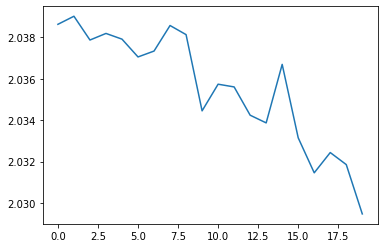

In [60]:
plt.plot(history.history['mae'])

[1728.12509955 1718.94636785 1698.82708541 1709.97934549 1707.90953242
 1697.63179703 1707.33116385 1719.26128803 1719.89143379]
[1752.530029296875, 1752.7900390625, 1745.530029296875, 1734.7099609375, 1745.719970703125, 1773.8399658203125, 1796.93994140625, 1818.510009765625, 1800.800048828125]
     index       y_test       y_pred
0        0  1739.489990  1739.489990
1        1  1728.125100  1741.752117
2        2  1718.946368  1744.357624
3        3  1698.827085  1747.021031
4        4  1709.979345  1749.398791
..     ...          ...          ...
439    439  3414.974553  2769.305310
440    440  3462.431184  2775.451632
441    441  3470.099860  2779.896752
442    442  3455.487904  2783.306680
443    443  3469.230681  2786.294355

[444 rows x 3 columns]


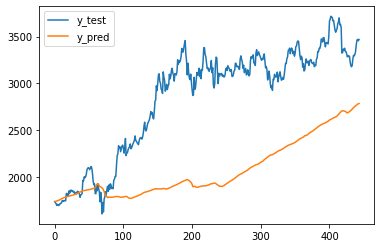

In [61]:
predictions = model.predict(X_test)
y_pred = pd.Series(predictions[:,0])
y = pd.Series(y_test.astype(float))
df = pd.DataFrame(dict(y_test = y, y_pred = y_pred)).reset_index()

y_temp = (y_test.reshape(nrow,)/100)*test[:-(windowSize+1)]
y_orig = np.append(test[0], y_temp)
y_orig = np.cumsum(y_orig)

print(y_orig[1:10])
print(test[1:10])

y_temp = (y_pred/100)*test[:-(windowSize+1)]
y_pred_back = np.append(test[0], y_temp)
y_pred_back = np.cumsum(y_pred_back)

df = pd.DataFrame(dict(y_test = y_orig, y_pred = y_pred_back)).reset_index()
print(df)
df[['y_test','y_pred']].plot()

In [62]:
## MAPE
ytt = df[['y_test']].values
ypp = df[['y_pred']].values
ptc_err = 100*(abs(ytt - ypp)/abs(ytt))
mape = ptc_err.mean() # mean absolute percentage error

## RMSE
sqerr = (ypp - ytt)**2
rmse = math.sqrt(sqerr.mean())

print("accuracy (measured as MAPE) is: ", round(mape,2), " %")
print("accuracy (measured as RMSE) is: ", round(rmse,2), " dollars")

accuracy (measured as MAPE) is:  25.2  %
accuracy (measured as RMSE) is:  877.14  dollars


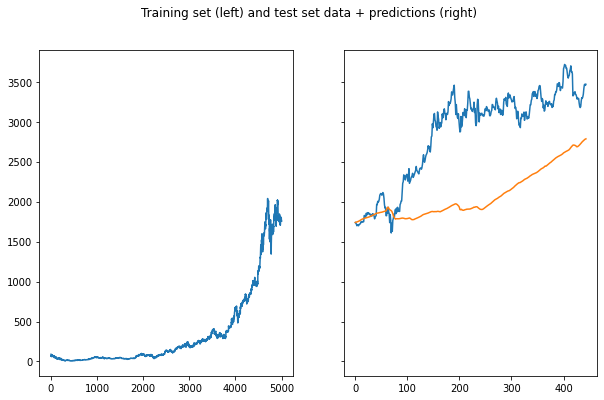

In [63]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10,6), sharey=True)
fig.suptitle('Training set (left) and test set data + predictions (right)')
ax1.plot(train)
ax2.plot(df[['y_test','y_pred']])

### More epochs?

In [64]:
history = model.fit(X_train,y_train,epochs=200, verbose=0, validation_data=(X_test, y_test))

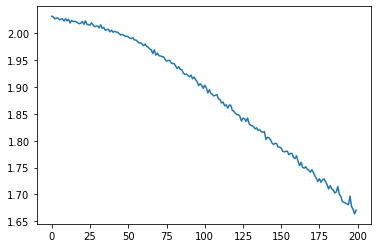

In [65]:
plt.plot(history.history['mae'])

[1728.12509955 1718.94636785 1698.82708541 1709.97934549 1707.90953242
 1697.63179703 1707.33116385 1719.26128803 1719.89143379]
[1752.530029296875, 1752.7900390625, 1745.530029296875, 1734.7099609375, 1745.719970703125, 1773.8399658203125, 1796.93994140625, 1818.510009765625, 1800.800048828125]
     index       y_test       y_pred
0        0  1739.489990  1739.489990
1        1  1728.125100  1739.599303
2        2  1718.946368  1742.263816
3        3  1698.827085  1747.705393
4        4  1709.979345  1752.756988
..     ...          ...          ...
439    439  3414.974553  2458.348584
440    440  3462.431184  2468.196398
441    441  3470.099860  2475.172970
442    442  3455.487904  2479.329368
443    443  3469.230681  2482.346661

[444 rows x 3 columns]


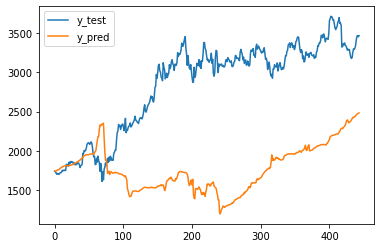

In [66]:
predictions = model.predict(X_test)
y_pred = pd.Series(predictions[:,0])
y = pd.Series(y_test.astype(float))
df = pd.DataFrame(dict(y_test = y, y_pred = y_pred)).reset_index()

y_temp = (y_test.reshape(nrow,)/100)*test[:-(windowSize+1)]
y_orig = np.append(test[0], y_temp)
y_orig = np.cumsum(y_orig)

print(y_orig[1:10])
print(test[1:10])

y_temp = (y_pred/100)*test[:-(windowSize+1)]
y_pred_back = np.append(test[0], y_temp)
y_pred_back = np.cumsum(y_pred_back)

df = pd.DataFrame(dict(y_test = y_orig, y_pred = y_pred_back)).reset_index()
print(df)
df[['y_test','y_pred']].plot()

In [67]:
## MAPE
ytt = df[['y_test']].values
ypp = df[['y_pred']].values
ptc_err = 100*(abs(ytt - ypp)/abs(ytt))
mape = ptc_err.mean() # mean absolute percentage error

## RMSE
sqerr = (ypp - ytt)**2
rmse = math.sqrt(sqerr.mean())

print("accuracy (measured as MAPE) is: ", round(mape,2), " %")
print("accuracy (measured as RMSE) is: ", round(rmse,2), " dollars")

accuracy (measured as MAPE) is:  36.04  %
accuracy (measured as RMSE) is:  1241.07  dollars


### Simple RNN, more epochs

In [68]:
model = Sequential() #initializing sequential model, layers can be added sequentially with model.add
model.add(SimpleRNN(10, input_shape=(windowSize,1))) #simple recurrent layer, 10 neurons & process 50x1 sequences
model.add(Dense(1,activation='linear')) #linear output because this is a regression problem
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_5 (SimpleRNN)     (None, 10)                120       
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 11        
Total params: 131
Trainable params: 131
Non-trainable params: 0
_________________________________________________________________


In [69]:
loss_function = 'mse'
optimizer_algorithm = 'Adam'
metrics_list = ['mae',tf.keras.metrics.RootMeanSquaredError()]
n_epochs = 200

model.compile(loss=loss_function, optimizer=optimizer_algorithm, metrics=metrics_list)
history = model.fit(X_train,y_train,epochs=n_epochs, verbose=0, validation_data=(X_test, y_test))

[1728.12509955 1718.94636785 1698.82708541 1709.97934549 1707.90953242
 1697.63179703 1707.33116385 1719.26128803 1719.89143379]
[1752.530029296875, 1752.7900390625, 1745.530029296875, 1734.7099609375, 1745.719970703125, 1773.8399658203125, 1796.93994140625, 1818.510009765625, 1800.800048828125]
     index       y_test       y_pred
0        0  1739.489990  1739.489990
1        1  1728.125100  1747.559280
2        2  1718.946368  1735.106899
3        3  1698.827085  1743.745800
4        4  1709.979345  1747.149078
..     ...          ...          ...
439    439  3414.974553  3219.130001
440    440  3462.431184  3241.984880
441    441  3470.099860  3273.703317
442    442  3455.487904  3272.308094
443    443  3469.230681  3259.149269

[444 rows x 3 columns]


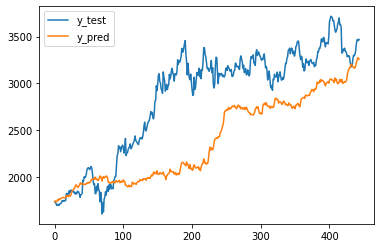

In [70]:
predictions = model.predict(X_test)
y_pred = pd.Series(predictions[:,0])
y = pd.Series(y_test.astype(float))
df = pd.DataFrame(dict(y_test = y, y_pred = y_pred)).reset_index()

y_temp = (y_test.reshape(nrow,)/100)*test[:-(windowSize+1)]
y_orig = np.append(test[0], y_temp)
y_orig = np.cumsum(y_orig)

print(y_orig[1:10])
print(test[1:10])

y_temp = (y_pred/100)*test[:-(windowSize+1)]
y_pred_back = np.append(test[0], y_temp)
y_pred_back = np.cumsum(y_pred_back)

df = pd.DataFrame(dict(y_test = y_orig, y_pred = y_pred_back)).reset_index()
print(df)
df[['y_test','y_pred']].plot()

In [71]:
## MAPE
ytt = df[['y_test']].values
ypp = df[['y_pred']].values
ptc_err = 100*(abs(ytt - ypp)/abs(ytt))
mape = ptc_err.mean() # mean absolute percentage error

## RMSE
sqerr = (ypp - ytt)**2
rmse = math.sqrt(sqerr.mean())

print("accuracy (measured as MAPE) is: ", round(mape,2), " %")
print("accuracy (measured as RMSE) is: ", round(rmse,2), " dollars")

accuracy (measured as MAPE) is:  15.78  %
accuracy (measured as RMSE) is:  574.11  dollars
